# TF Data loading - images

This is a tutorial on how to load image data in `tensorflow`.

In [1]:
!export TF_ENABLE_ONEDNN_OPTS=0

In [2]:
import tensorflow as tf

2023-10-31 17:14:31.827804: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-31 17:14:31.829288: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 17:14:31.853444: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 17:14:31.853474: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 17:14:31.853490: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

## Download the dataset

https://www.tensorflow.org/tutorials/load_data/images#download_the_flowers_dataset

In [4]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url,
                                  extract=True,
                                  cache_dir='/tmp/keras/')
data_dir = pathlib.Path(archive).with_suffix('')

In [5]:
# Total nof images
len(list(data_dir.glob('*/*.jpg')))

3670

In [6]:
roses = list(data_dir.glob('roses/*'))

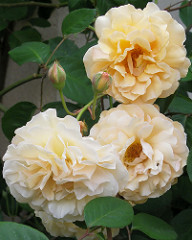

In [7]:
PIL.Image.open(str(roses[10]))

## Load data using a Keras utility

https://www.tensorflow.org/tutorials/load_data/images#load_data_using_a_keras_utility

Load images using a `Keras` utility: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

### Check image dimensions

In [8]:
from matplotlib.pyplot import imread
image = imread(roses[0])
image.shape

(228, 240, 3)

### Load the data usint the keras utility

This utility is very powerful because it takes care of loading, resizing and splitting the data. Additionally, it can shuffle the data. Lastly, it labels the data based on the directories they're placed in. See docstring.

In [9]:
image_height = 180
image_width = 180
batch_size = 32

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="training",
seed=42,
image_size=(image_height, image_width),
batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset='validation',
seed=42,
image_size=(image_height, image_width),
batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
# These are extracted based on their directoreies
train_ds.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [13]:
nof_classes = len(train_ds.class_names)

### Visualize some data

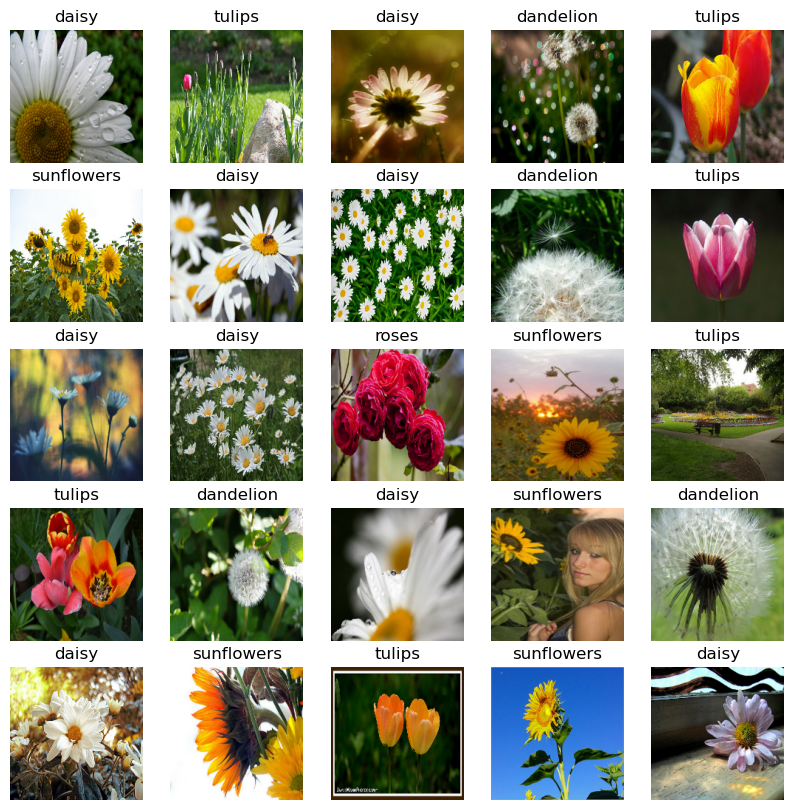

In [14]:
import matplotlib.pyplot as plt

images_to_plot = 25
# This was difficult to understand what's happening here.
# .take() will create a new dataset from train_ds and return it as an iterator.
# Since we batched train_ds into 32 images per batch, .take() returns an iterator of 32 images.
# See print(len(images))

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    #print(len(images))
    for i in  range(images_to_plot):
        ax = plt.subplot(5, 5, i+1) # So you don't have to do the flatten part of the axis
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

## Normalize the data - Standardize the data

In general you should seek to make your input values small.

RGB range is [0, 255], here we'll convert it to [0, 1] using tf.keras.layers.Rescaling - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling

In [15]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [16]:
# Demo - skip running this block
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [17]:
first_image

<tf.Tensor: shape=(180, 180, 3), dtype=float32, numpy=
array([[[0.0678976 , 0.17866014, 0.00734205],
        [0.07300654, 0.17888889, 0.01026144],
        [0.07791939, 0.1759586 , 0.01125272],
        ...,
        [0.08576258, 0.17639428, 0.09186275],
        [0.09130747, 0.16843149, 0.09130723],
        [0.07868186, 0.16140509, 0.08671014]],

       [[0.06558824, 0.1714706 , 0.005     ],
        [0.07343138, 0.17931373, 0.01330066],
        [0.07343138, 0.17931373, 0.00600218],
        ...,
        [0.07299575, 0.16362746, 0.07909592],
        [0.08186282, 0.1643462 , 0.08294109],
        [0.07855117, 0.17051196, 0.08531588]],

       [[0.06623095, 0.1721133 , 0.01132898],
        [0.07009804, 0.1759804 , 0.01519608],
        [0.06617647, 0.17990197, 0.00027233],
        ...,
        [0.06971687, 0.15980393, 0.07554471],
        [0.07810433, 0.16045752, 0.07941168],
        [0.08327877, 0.15778857, 0.0793572 ]],

       ...,

       [[0.        , 0.04215686, 0.        ],
        [0.  

In [18]:
np.max(first_image), np.min(first_image)

(0.9906863, 0.0)

Yo ucan use ths layer to apply it to the dataset by calling `Dataset.map`.

An alternative approach is to include this (normalization layer) in your model.

You can also include a `Resizing` layer in your model using `tf.keras.layers.Resizing`

## Configure data for performance

`Dataset.cache()` : keeps the images in memory. The first epoch trains slow because the images are being loaded into memory.

`Dataset.prefetch()`: overlaps data preprocessing and model execution while training.

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Train the model

In this tutorial we create a model consisting of the layeres shown in the code. This setup is considered as the **standard when it comes to training model on images**, see https://www.tensorflow.org/tutorials/images/classification

But why? I should look into some writeups about this.

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(nof_classes)
])

Notive the 1st layer is for rescaling.

Notice the last layer outputs the name of the class of the flower.

## Compile the model

We use https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy as a loss function because there are two or more labels.

A note on losses:

If your labels are integers (e.g. [[1], [23], [43], [16]...]), use tf.keras.losses.SparseCategoricalCrossentropy()
If your labels are one-hot encoded (e.g. [0, 1, 0, 0, 1, 0...]), use tf.keras.losses.CategoricalCrossEntropy()

Ref: https://github.com/mrdbourke/zero-to-mastery-ml/blob/master/section-4-unstructured-data-projects/end-to-end-dog-vision-v2.ipynb

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Train the model

This tutorial does not include the usage of callbacks. I should create 2 callbacks which track that the loss continues to decrease and accuracy continues to increase.

In [24]:
epochs = 10

history = model.fit(
train_ds,
validation_data=val_ds,
epochs=epochs)

Epoch 1/10
92/92 [==============================] - 8s 85ms/step - loss: 0.9993 - accuracy: 0.6035 - val_loss: 1.0547 - val_accuracy: 0.5954
Epoch 2/10
92/92 [==============================] - 8s 85ms/step - loss: 0.8222 - accuracy: 0.6901 - val_loss: 0.9511 - val_accuracy: 0.6335
Epoch 3/10
92/92 [==============================] - 8s 84ms/step - loss: 0.6067 - accuracy: 0.7701 - val_loss: 1.0610 - val_accuracy: 0.6104
Epoch 4/10
92/92 [==============================] - 8s 85ms/step - loss: 0.4309 - accuracy: 0.8457 - val_loss: 1.1884 - val_accuracy: 0.6281
Epoch 5/10
92/92 [==============================] - 8s 87ms/step - loss: 0.3978 - accuracy: 0.8525 - val_loss: 1.5869 - val_accuracy: 0.5899
Epoch 6/10
92/92 [==============================] - 8s 91ms/step - loss: 0.2697 - accuracy: 0.9101 - val_loss: 2.0171 - val_accuracy: 0.5763
Epoch 7/10
92/92 [==============================] - 8s 91ms/step - loss: 0.1994 - accuracy: 0.9339 - val_loss: 1.8259 - val_accuracy: 0.6063
Epoch 8/10
92

In [29]:
history